# Assignment: Financial Applications of Time Series
* Choose either the Signal Frontier Analysis application or Future Contract Rolling application.
    * Case studies start on page 345
* Use different stocks than those shown in examples.
* Create iPython Notebook, including code, output, and graphics.
* Include an introduction in your notebook to give background on your application.
* Be sure to explain calculations and output in the appropriate places.
* List outside references if used.


Case study write-ups are to be “technical report ready,” which basically means that the write-up is suitable for public viewing.

Your name must be at the beginning of the notebook.
The notebook should divided into an abstract, an introduction, a methods section, a results section, and a future work/discussion/conclusion section.
Use an easy-to-read variable-width font (I like Ariel, Helvetica, and Geneva font) with a minimum of 11 point font.
Relevant code and output must be explained in the notebook as close to the code/output as possible.
Any graphics generated using the code must be explained in the notebook as close to the graphic as possible.

## MUST SUBMIT AS A WORD DOC IN ADDITION TO ANYTHING DONE IN IPYTHON

In [37]:
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as web
from dateutil.parser import parse
from pyfinance.ols import PandasRollingOLS
from datetime import datetime, timedelta, date
pd.options.display.max_rows = 12
np.set_printoptions(precision=4, suppress=True)


## Future Contract Rolling

In [23]:
## First I am going to replicate the analysis, then change things up
# price = web.get_data_yahoo('SPY')['Adj Close'] * 10
price = web.get_data_yahoo('NFLX')['Adj Close'] * 10# basically getting 10 futures contracts.

In [10]:
price

Date
2010-01-04      7.640000
2010-01-05      7.358572
2010-01-06      7.617143
2010-01-07      7.485714
2010-01-08      7.614286
2010-01-11      7.604286
                 ...    
2019-02-22    363.019989
2019-02-25    363.910004
2019-02-26    364.970001
2019-02-27    362.869995
2019-02-28    358.100006
2019-03-01    357.320007
Name: Adj Close, Length: 2305, dtype: float64

In [41]:
# expires = {'ESU2': datetime(2012, 9, 21),
#            'ESZ2': datetime(2012, 12, 21)}

expires = {'ESU2': date(2019, 9, 21),
           'ESZ2': date(2019, 12, 21)}
expires = Series(expires).sort_values()

In [42]:
expires

ESU2    2019-09-21
ESZ2    2019-12-21
dtype: object

In [61]:
now = date.today()
expires[-1]

n_days = abs(now - expires[-1])
n_days = n_days.days
n_days

294

In [62]:
np.random.seed(12347)
N = n_days
walk = (np.random.randint(0, 200, size=N) - 100) * 0.25
perturb = (np.random.randint(0, 20, size=N) - 10) *0.25
walk = walk.cumsum()

rng = pd.date_range(price.index[0], periods=len(price) + N, freq='B')
near = np.concatenate([price.values, price.values[-1] + walk])
far = np.concatenate([price.values, price.values[-1] + walk + perturb])
prices = DataFrame({'ESU2': near, 'ESZ2': far}, index=rng)

In [99]:
rng

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2019-12-06', '2019-12-09', '2019-12-10', '2019-12-11',
               '2019-12-12', '2019-12-13', '2019-12-16', '2019-12-17',
               '2019-12-18', '2019-12-19'],
              dtype='datetime64[ns]', length=2599, freq='B')

Text(0, 0.5, 'Price')

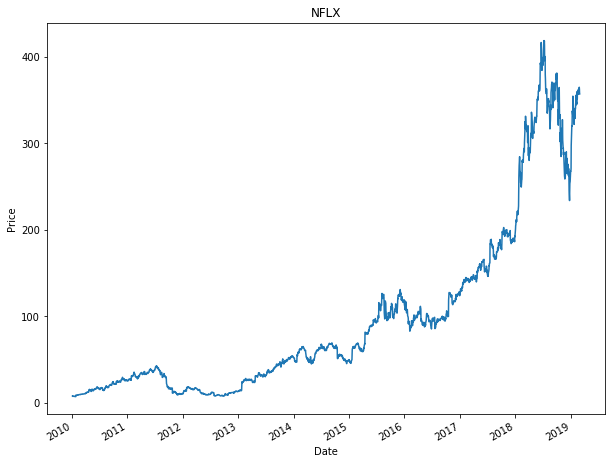

In [27]:
# plot prices up to the first expiry date
price = web.get_data_yahoo('NFLX')['Adj Close'] # basically getting 10 futures contracts.
price.plot(figsize=(10,8), title="NFLX").set_ylabel("Price")

In [63]:
prices.tail()

,ESU2,ESZ2
2019-12-13,324.570007,324.320007
2019-12-16,335.820007,334.070007
2019-12-17,329.570007,327.320007
2019-12-18,343.070007,343.070007
2019-12-19,342.820007,341.320007


In [90]:
price = pd.DataFrame(price)

In [91]:
combined = pd.concat(price, prices['ESU2'][price.index[-1]:])

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

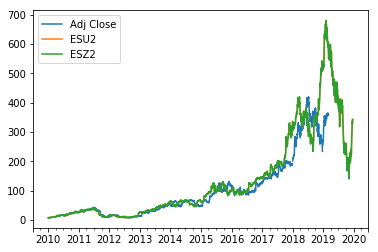

In [98]:
combined = price.join(prices, how='outer')
combined.plot()

Text(0, 0.5, 'Price')

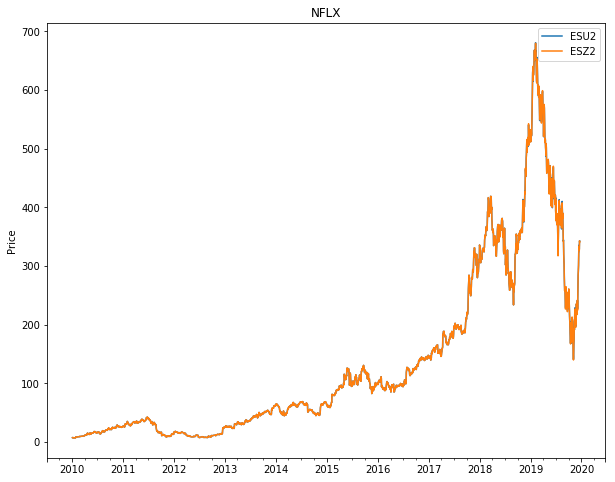

In [106]:
prices.plot(figsize=(10,8), title="NFLX").set_ylabel("Price")

In [107]:
prices.tail()

,ESU2,ESZ2
2019-12-13,324.570007,324.320007
2019-12-16,335.820007,334.070007
2019-12-17,329.570007,327.320007
2019-12-18,343.070007,343.070007
2019-12-19,342.820007,341.320007


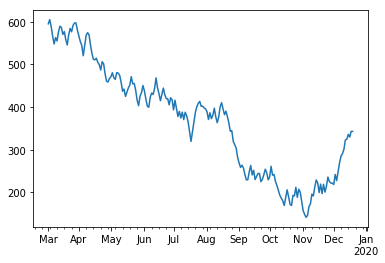

In [103]:
prices['ESU2'][price.index[-1]:].plot()

In [105]:
def get_roll_weights(start, expiry, items, roll_periods=5):
    # start : first date to compute weighting DataFrame
    # expiry : Series of ticker -> expiration dates
    # items : sequence of contract names

    dates = pd.date_range(start, expiry[-1], freq='B')
    weights = DataFrame(np.zeros((len(dates), len(items))),
                        index=dates, columns=items)

    prev_date = weights.index[0]
    for i, (item, ex_date) in enumerate(expiry.iteritems()):
        if i < len(expiry) - 1:
            weights.ix[prev_date:ex_date - pd.offsets.BDay(), item] = 1
            roll_rng = pd.date_range(end=ex_date - pd.offsets.BDay(),
                                     periods=roll_periods + 1, freq='B')

            decay_weights = np.linspace(0, 1, roll_periods + 1)
            weights.ix[roll_rng, item] = 1 - decay_weights
            weights.ix[roll_rng, expiry.index[i + 1]] = decay_weights
        else:
            weights.ix[prev_date:, item] = 1

        prev_date = ex_date

    return weights



In [110]:
rweights = get_roll_weights(prices.index[0], expires, prices.columns)

/home/kyle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]
/home/kyle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/kyle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/kyle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: Depr

In [111]:
rweights

,ESU2,ESZ2
2010-01-04,1.0,0.0
2010-01-05,1.0,0.0
2010-01-06,1.0,0.0
2010-01-07,1.0,0.0
2010-01-08,1.0,0.0
2010-01-11,1.0,0.0
...,...,...
2019-12-13,0.0,1.0
2019-12-16,0.0,1.0
2019-12-17,0.0,1.0


In [112]:
rweights.ix['2019-09-12':'2019-09-21']

/home/kyle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


,ESU2,ESZ2
2019-09-12,1.0,0.0
2019-09-13,1.0,0.0
2019-09-16,0.8,0.2
2019-09-17,0.6,0.4
2019-09-18,0.4,0.6
2019-09-19,0.2,0.8
2019-09-20,0.0,1.0


In [113]:
rolled_returns = (prices.pct_change() * rweights).sum(1)

In [114]:
rolled_returns

2010-01-04    0.000000
2010-01-05   -0.036836
2010-01-06    0.035139
2010-01-07   -0.017254
2010-01-08    0.017176
2010-01-11   -0.001313
                ...   
2019-12-13    0.005425
2019-12-16    0.030063
2019-12-17   -0.020205
2019-12-18    0.048118
2019-12-19   -0.005101
2019-12-20    0.000000
Freq: B, Length: 2600, dtype: float64

In [122]:
(prices.pct_change() * rweights).sum()

ESU2    4.877854
ESZ2    0.528905
dtype: float64

In [116]:
rolled_returns.ix['2019-09-12':'2019-09-21']

/home/kyle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


2019-09-12    0.059459
2019-09-13   -0.084659
2019-09-16    0.047280
2019-09-17   -0.082145
2019-09-18    0.030070
2019-09-19    0.018467
2019-09-20    0.013398
Freq: B, dtype: float64

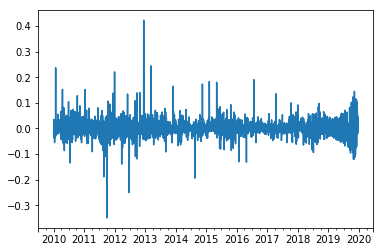

In [115]:
rolled_returns.plot()